# 3. Random Forest

### 3.1 Load data

We load our and display output from data preparation section and continue to our first model, based on logistic regression. (See notebook "loan_default_data_preparation" for details on the data generation and distributions)



In [ ]:
import pandas as pd
import numpy as np
import pickle
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import make_scorer, recall_score, classification_report,
import logging
import matplotlib.pyplot as plt
import plotly.express as px

# Load the data
with open('data/loan_data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

df = loaded_data['df']
metadata_df = loaded_data['metadata_df']
numeric_features = loaded_data['numeric_features']  # 
categorical_features = loaded_data['categorical_features']
target_feature = loaded_data['target_feature']

# Display metadata of the synthetic data distribution
# Style the DataFrame for better readability
styled_df = metadata_df.style.set_properties(**{'text-align': 'left'})
styled_df.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])

# Display the styled DataFrame
display(styled_df)




,Feature,Skewness Description,Mean/Mode Assumptions and Distribution Details
0,Income,"Positively skewed. Higher concentration of individuals with lower incomes, with fewer high-income earners.","Mean: €4000, Distribution: Log-normal with σ = 0.5"
1,Loan_Amount,"Positively skewed. Loan amounts are concentrated towards lower to moderate values, with fewer large loan amounts.","Mean: €175,000, Distribution: Log-normal with σ = 0.5"
2,Credit_Score,"Negatively skewed. Most people have good to excellent credit scores, with fewer individuals having very low credit scores.","Mean: 700, Mode: 750, Distribution: Normal (reversed) with μ = 100 and σ = 50"
3,Employment_Status,"Binary distribution. Higher proportion of the population being employed, heavily weighted towards employment.","Mode: Employed, Distribution: Binary with p = 0.9"
4,Debt_to_Income,"Positively skewed. More individuals with lower ratios, but significant instances of high debt relative to income.","Mean: 0.6, Distribution: Beta (α = 2, β = 5) scaled to [0, 1.2]"
5,Loan_Term,Discrete uniform. Distributed across specific intervals with peaks at common loan terms like 20 and 30 years.,"Mode: 20 years, Distribution: Discrete with p = [0.1, 0.2, 0.3, 0.1, 0.3]"
6,Age,"Approximately normal. Centered around peak working ages (30-45 years), with fewer young and old applicants.","Mean: 35, Distribution: Normal with μ = 35 and σ = 10, clipped to [18, 75]"
7,Home_Ownership,"Binary distribution. Higher proportion of the population owning homes, heavily weighted towards ownership.","Mode: Own, Distribution: Binary with p = 0.7"
8,Default,"Positively skewed. Default rates are typically low, with a small percentage representing defaults.","Mean: 0.15, Distribution: Top 15% of risk scores"


In [3]:
# Combine all features
all_features = numeric_features + categorical_features + [target_feature]

# Filter the dataframe
df_filtered = df[all_features]

df_filtered.head()

,Income,Loan_Amount,Credit_Score,Debt_to_Income,Age,Employment_Status,Home_Ownership,Loan_Term,Default
0,5127.670373,183807.505965,848.470271,0.331069,39,Employed,Own,30,0
1,3732.813394,169479.480329,850.000000,0.193608,21,Employed,Rent,30,0
2,5529.728012,281654.558991,850.000000,0.463659,44,Employed,Own,25,0
3,8566.072041,376606.751901,850.000000,0.433488,44,Employed,Rent,15,0
4,3558.067903,246708.985583,850.000000,0.222574,35,Employed,Own,20,0


### 3.2 Form Random Forest Model

#### 3.2.1 Data preparation and dataset splitting


In [4]:
random_seed = 42
target_feature = 'Default'

# Separate features (X) and target (y)
X = df_filtered.drop(columns=[target_feature])
y = df_filtered[target_feature]

# Label Encoding for categorical features
le = LabelEncoder()
for col in categorical_features:  # Assuming you have a list of categorical features
    X[col] = le.fit_transform(X[col])

# Standardize numerical features 
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])  # Assuming you have a list of numerical features

# Split into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y
)

# Split the training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=random_seed, stratify=y_train_val
)


#### 3.2.2 Model training

We train our Random Forest model with balanced class weights and grid search scoring based on class 1 (defaults) recall. For time, we run a simplified hyperparameter grid

In [19]:

# Configure logging
logging.basicConfig(filename='data/grid_search_log.txt', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

"""
# Hyperparameter grid (adjust as needed)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
"""

# Simplified hyperparameter grid (adjust as needed)
param_grid = {
    'n_estimators': [200],
    'max_depth': [5, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [2]
}

# Custom scorer for recall of class 1 (defaulters)
scorer = make_scorer(recall_score, pos_label=1)

# Create and fit the grid search
rf = RandomForestClassifier(random_state=random_seed, class_weight="balanced")
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=scorer, verbose=3)
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and refit the model on the entire training data
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the final model with the best parameters
model = RandomForestClassifier(**best_params, random_state=random_seed, class_weight="balanced")
model.fit(X_train, y_train)

# Evaluation on the validation set
y_pred_val = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
report_val = classification_report(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val, pos_label=1)

print(f'Validation Accuracy: {accuracy_val:.4f}')
print('Validation Classification Report:\n', report_val)
print(f'Validation Recall for Class 1: {recall_val:.4f}')

# Log the best parameters and score
logging.info(f"Best Parameters: {best_params}")
logging.info(f"Best Class 1 Recall Score: {best_score:.4f}")

# Log the full grid search results
results_df = pd.DataFrame(grid_search.cv_results_)  # Convert to DataFrame for easier logging
logging.info("Grid Search CV Results:")
for _, row in results_df.iterrows():  
    logging.info(row.to_json())
logging.shutdown()

# Save the model
with open('model/random_forest_model_train.pkl', 'wb') as file:
    pickle.dump(model, file)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.764 total time=   4.3s
[CV 2/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.730 total time=   5.4s
[CV 3/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.782 total time=   4.9s
[CV 4/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.744 total time=   5.0s
[CV 5/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.741 total time=   5.0s
[CV 1/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.695 total time=   7.9s
[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.658 total time=   7.0s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.710 total time=   6.8s
[

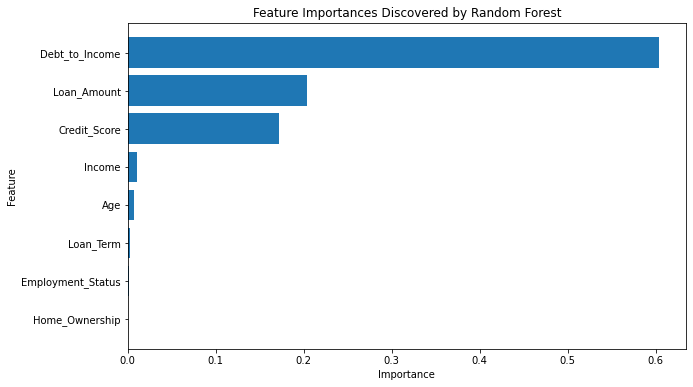

In [22]:
# Extract feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features = features.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features['Feature'], features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances Discovered by Random Forest')
plt.gca().invert_yaxis()
plt.show()

#### 3.2.3 Model evaluation
We note from the training log that larger max depth resulted in decreasing performance, suggesting overfitting. 

Further hyperparameter tunign might improve the model, but we leave that as a further improvement point. We also note that the results from our random forest are very similar to our logistic regression model, which may imply that we are reaching the best possible identifications based on the underlying synthetic data. 

The feature importances discovered by the model fit our observations in the data exploration phase on key features, though the random forest places more weight for loan_amount than for credit_score

We run our final model on the validation and test set

In [20]:
# Extract mean test scores (accuracy) for each parameter combination
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Extract parameters for each combination
params = grid_search.cv_results_['params']

# Print results in a table format
for score, param in zip(mean_test_scores, params):
    if not np.isnan(score): # Filter out NaN values that result from the memory issue
        print(f"Parameters: {param}, Mean Accuracy: {score:.4f}")


Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}, Mean Accuracy: 0.7522
Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}, Mean Accuracy: 0.6802


In [21]:
# Train the final model with best parameters
model = RandomForestClassifier(**best_params, random_state=random_seed, class_weight="balanced")
model.fit(X_train, y_train)


# Evaluation on the validation set
y_pred_val = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
report_val = classification_report(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val, pos_label=1)

print(f'Validation Accuracy: {accuracy_val:.4f}')
print('Validation Classification Report:\n', report_val)
print(f'Validation Recall for Class 1: {recall_val:.4f}')

# Log the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
logging.info(f"Best Parameters: {best_params}")
logging.info(f"Best Class 1 Recall Score: {best_score:.4f}")

# Log the full grid search results
results_df = pd.DataFrame(grid_search.cv_results_)  # Convert to DataFrame for easier logging
logging.info("Grid Search CV Results:")
for _, row in results_df.iterrows():  
    logging.info(row.to_json())
logging.shutdown()

# Save the model
with open('model/random_forest_model_valid.pkl', 'wb') as file:
    pickle.dump(model, file)

# Evaluation on the test set
y_pred_test = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test, pos_label=1)

print(f'Test Accuracy: {accuracy_test:.4f}')
print('Test Classification Report:\n', report_test)
print(f'Test Recall for Class 1: {recall_test:.4f}')


Validation Accuracy: 0.7399
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.74      0.83      8388
           1       0.35      0.75      0.48      1612

    accuracy                           0.74     10000
   macro avg       0.65      0.74      0.65     10000
weighted avg       0.84      0.74      0.77     10000

Validation Recall for Class 1: 0.7463
Test Accuracy: 0.7297
Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.73      0.82      8388
           1       0.34      0.74      0.47      1612

    accuracy                           0.73     10000
   macro avg       0.64      0.73      0.64     10000
weighted avg       0.84      0.73      0.76     10000

Test Recall for Class 1: 0.7413


We note that the test and validation sets display remarkable consistency in results, which are also in line with our linear regression model.  

### 3.3 Analysis of Validation Results

- **Overall Accuracy**: The validation accuracy is 73.99%, indicating that approximately three-quarters of the predictions were correct.
- **Class 1 (Defaulters)**:
  - **Precision**: Lower at 35%, indicating a relatively high number of false positives.
  - **Recall**: High at 75%, showing the model's effectiveness in identifying a substantial proportion of actual defaulters.
  - **F1-Score**: Moderate at 0.48, suggesting room for improvement in balancing precision and recall for defaulters.
- **Class 0 (Non-defaulters)**:
  - **Precision**: High at 94%, indicating the model is very accurate when it predicts a non-defaulter.
  - **Recall**: Moderate at 74%, meaning the model correctly identifies a significant portion of non-defaulters.
  - **F1-Score**: Strong at 0.83, reflecting a good balance between precision and recall for this class.

We propose that our key interest is class 1 recall, which is useful at 75% but surely has space for improvement. This is a highly similar result to our logistic regression model, which might suggest a best possible result given our synthetic dataset with limited features and manufactured randomness and correlations. 

However, we will mention possible improvement methods below: 


### 3.4 Possible Next Steps for Better Results

#### Improving Results with Random Forest

1. **Hyperparameter Tuning**:
   - **Increase Tree Count**: Raise `n_estimators` to ensure the model benefits from a larger ensemble (e.g., `[100, 200, 300]`).
   - **Optimize Tree Depth**: Experiment with different values for `max_depth` to prevent overfitting and underfitting (e.g., `[3, 5, 7, 10]`).
   - **Adjust Splitting Criteria**: Tune `min_samples_split` and `min_samples_leaf` to control the complexity of the trees (e.g., `[2, 5, 10]` for `min_samples_split` and `[1, 2, 4]` for `min_samples_leaf`).

2. **Class Imbalance Handling**:
   - **Over-sampling/Under-sampling**: Apply techniques such as SMOTE (Synthetic Minority Over-sampling Technique) or under-sampling the majority class to balance the dataset.
   - **Cost-sensitive Learning**: Integrate class weights directly into the model to penalize misclassification of the minority class more heavily.

3. **Feature Engineering**:
   - **Create Interaction Features**: Introduce features that capture interactions between existing features.
   - **Polynomial Features**: Generate polynomial features to capture non-linear relationships.

#### Improving Overall Results

1. **Feature Engineering** (if using a real life dataset with richer features):
   - **Domain-Specific Features**: Develop new features based on domain knowledge, such as ratios, trends, or categorical groupings.
   - **Feature Selection**: Use techniques such as Recursive Feature Elimination (RFE) to identify and retain the most significant features.
   - **Normalization/Standardization**: Ensure features are appropriately scaled to enhance model performance.

2. **Other Models**:
   - **Gradient Boosting Machines (GBM)**: Models like XGBoost, LightGBM, and CatBoost may outperform random forests by focusing on correcting the mistakes of previous models.
   - **Neural Networks**: Implement deep learning models for their ability to capture complex patterns in large datasets.

3. **Cross-Validation**:
   - **K-Fold Cross-Validation**: Use k-fold cross-validation to better assess model performance and ensure it generalizes well to unseen data.
   - **Stratified Sampling**: Ensure each fold in cross-validation maintains the same class distribution as the original dataset.

Implementing these strategies could help improve the model's performance, especially in correctly identifying defaulters, and ensure a more balanced and robust predictive system.
